<a href="https://colab.research.google.com/github/DHKing7/capstonedesign/blob/main/Pothole_Segmentation_deeplabv3plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-x9g69380
  Running command git clone -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-x9g69380
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265311 sha256=146c0b330ebad70b683880a2bcb516c52c432127f5d7bede0fc0be133278e3c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9a5fghv/wheels/6e/c9/59/56484d4d5ac1ab292a452b4c3870277256551505954fc4a1db
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-aar1vok1
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-aar1vok1


In [ ]:
%cd '/content'
!unzip  -qq '/content/drive/MyDrive/캡스톤디자인2/pothole600.zip'

/content


In [ ]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
import os, cv2
import numpy as np
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
DATA_DIR = 'pothole600/'

x_train_dir = os.path.join(DATA_DIR, 'training/rgb')
y_train_dir = os.path.join(DATA_DIR, 'training/label')

x_valid_dir = os.path.join(DATA_DIR, 'validation/rgb')
y_valid_dir = os.path.join(DATA_DIR, 'validation/label')

x_test_dir = os.path.join(DATA_DIR, 'testing/rgb')
y_test_dir = os.path.join(DATA_DIR, 'testing/label')

In [ ]:
class_dict = pd.read_csv('label_class_dict.csv')
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'pothole']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'pothole']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'pothole']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
def visualize(**images):

    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):

    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)

    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
import torchvision.models as models
from PIL import Image

class MyDataset(torch.utils.data.Dataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

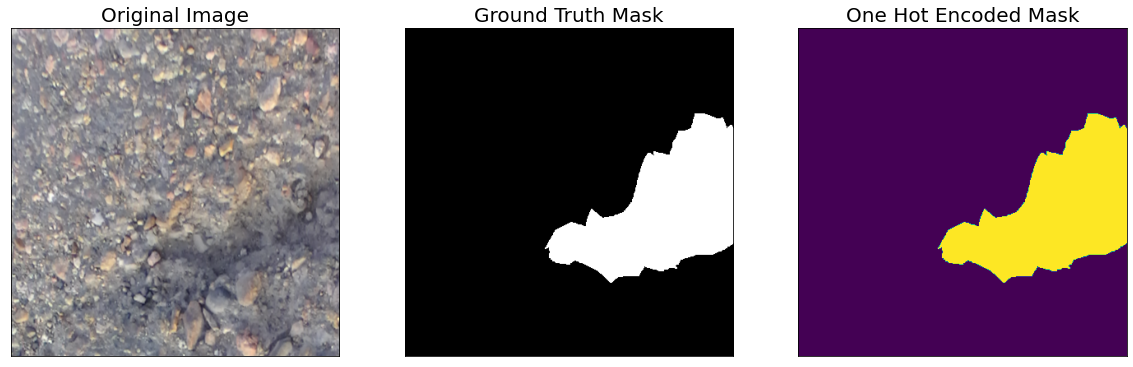

In [ ]:
dataset = MyDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [    
        album.Resize(256, 256),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None): 
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

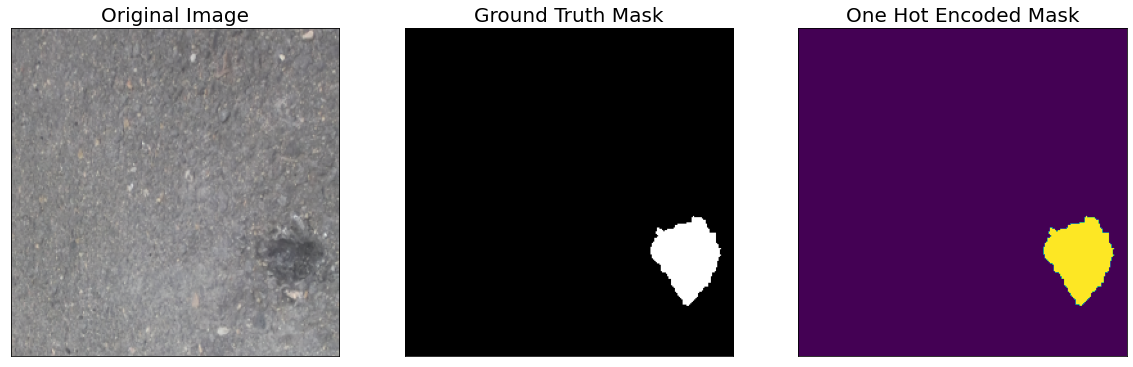

In [ ]:
augmented_dataset = MyDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)


image, mask = augmented_dataset[random_idx]
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' 

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
!pip install -U albumentations
!pip install --upgrade opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 8.8 MB/s 
     |████████████████████████████████| 48.3 MB 67 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 81 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
train_dataset = MyDataset(
    x_train_dir, y_train_dir, 
    class_rgb_values = select_class_rgb_values,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = MyDataset(
    x_valid_dir, y_valid_dir, 
    class_rgb_values = select_class_rgb_values,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

In [ ]:
TRAINING = True

EPOCHS = 20

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

if os.path.exists('best_model.pth'):
    model = torch.load('best_model.pth', map_location=DEVICE)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)


        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 45/45 [00:07<00:00,  5.66it/s, dice_loss - 0.1635, iou_score - 0.9331]
Model saved!

Epoch: 1
valid: 100%|██████████| 45/45 [00:07<00:00,  5.66it/s, dice_loss - 0.144, iou_score - 0.9565]
Model saved!

Epoch: 2
valid: 100%|██████████| 45/45 [00:07<00:00,  5.69it/s, dice_loss - 0.0791, iou_score - 0.957]
Model saved!

Epoch: 3
valid: 100%|██████████| 45/45 [00:07<00:00,  5.63it/s, dice_loss - 0.03551, iou_score - 0.9552]

Epoch: 4
valid: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s, dice_loss - 0.0398, iou_score - 0.9521]

Epoch: 5
valid: 100%|██████████| 45/45 [00:08<00:00,  5.62it/s, dice_loss - 0.08379, iou_score - 0.901]

Epoch: 6
valid: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s, dice_loss - 0.06473, iou_score - 0.9137]

Epoch: 7
valid: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s, dice_loss - 0.08311, iou_score - 0.9121]

Epoch: 8
valid: 100%|██████████| 45/45 [00:08<00:00,  5.62it/s, dice_loss - 0.07181, iou_score - 0.9171]

Epoch: 9
vali

In [ ]:
if os.path.exists('best_model.pth'):
    best_model = torch.load('best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

elif os.path.exists('best_model.pth'):
    best_model = torch.load('best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


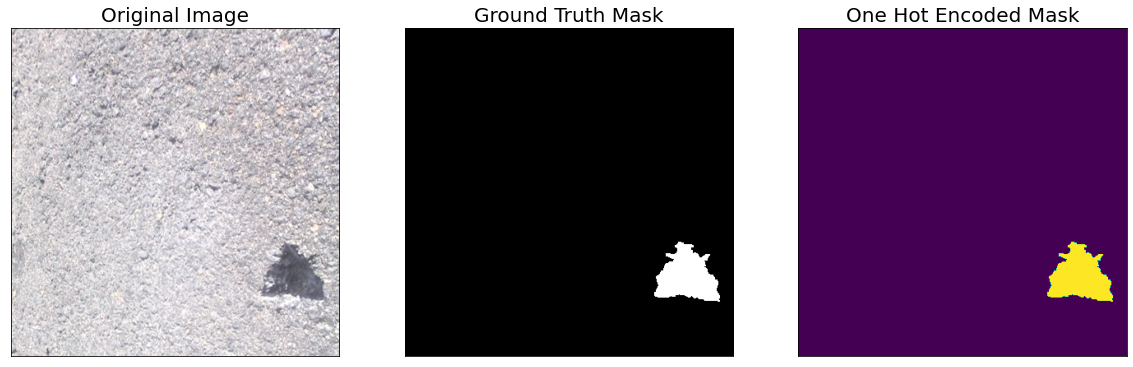

In [ ]:
test_dataset = MyDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)


test_dataset_vis = MyDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)


random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    pred_mask = np.transpose(pred_mask,(1,2,0))

    pred_pothole_heatmap = pred_mask[:,:,select_classes.index('pothole')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_pothole_heatmap = pred_pothole_heatmap
    )

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 180/180 [00:11<00:00, 15.47it/s, dice_loss - 0.08342, iou_score - 0.8642]
Evaluation on Test Data: 
Mean IoU Score: 0.8642
Mean Dice Loss: 0.0834


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.284982,0.126729,0.088836,0.067704,0.061875,0.056661,0.047917,0.040743,0.035298,0.039930,0.039989,0.034737,0.039130,0.034560,0.029273,0.028553,0.023380,0.022092,0.036340,0.045905
iou_score,0.774230,0.904321,0.912594,0.924124,0.919590,0.921883,0.930717,0.940216,0.947307,0.937615,0.936089,0.943831,0.935793,0.941829,0.951119,0.951957,0.960564,0.962892,0.937757,0.920712


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 180/180 [00:11<00:00, 15.51it/s, dice_loss - 0.08342, iou_score - 0.8642]
Evaluation on Test Data: 
Mean IoU Score: 0.8642
Mean Dice Loss: 0.0834


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.284982,0.126729,0.088836,0.067704,0.061875,0.056661,0.047917,0.040743,0.035298,0.039930,0.039989,0.034737,0.039130,0.034560,0.029273,0.028553,0.023380,0.022092,0.036340,0.045905
iou_score,0.774230,0.904321,0.912594,0.924124,0.919590,0.921883,0.930717,0.940216,0.947307,0.937615,0.936089,0.943831,0.935793,0.941829,0.951119,0.951957,0.960564,0.962892,0.937757,0.920712


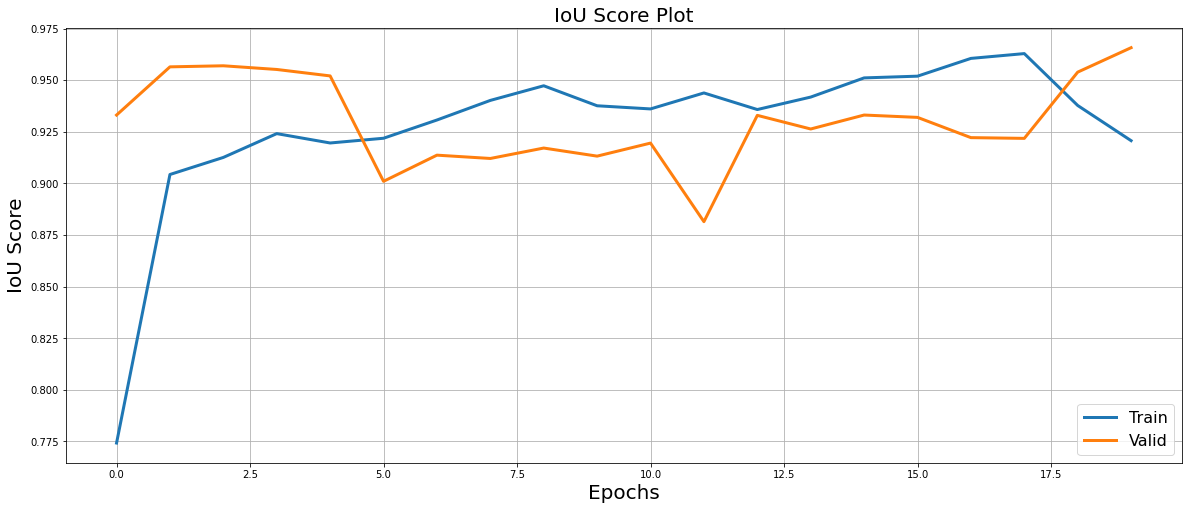

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

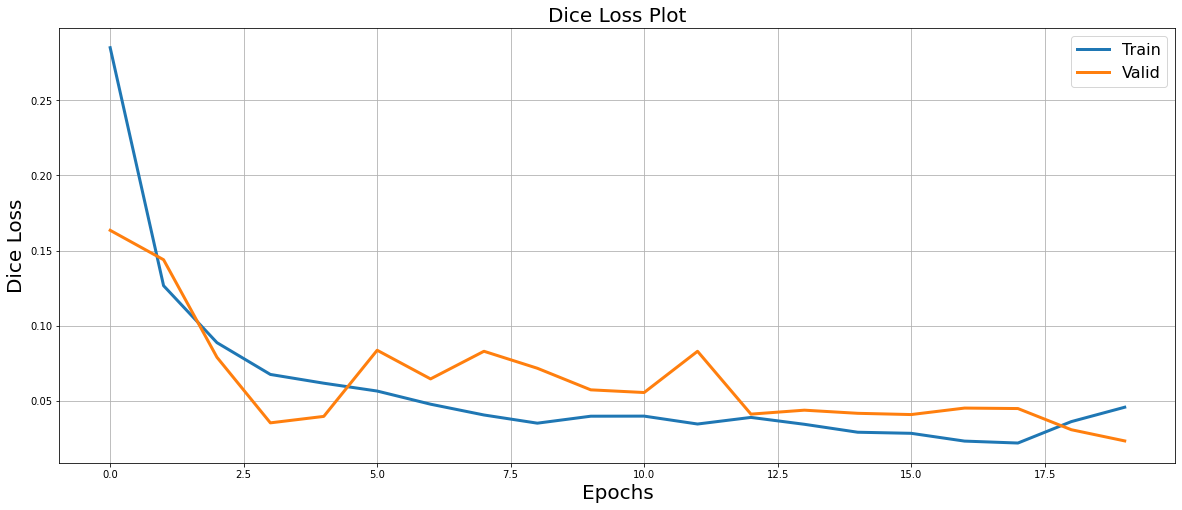

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()